In [1]:
from symbol import parameters

from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython.display import Markdown, display
from striprtf.striprtf import rtf_to_text
import os
from dotenv import load_dotenv
import warnings
import tiktoken
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec
from openai import OpenAI
import time
from src.embeddings import *
from src.data_processing import *
import tqdm
import itertools
import tqdm
from langchain_text_splitters import MarkdownHeaderTextSplitter
import pypandoc

from src.embeddings import get_embedding

# This will download and install Pandoc if it's not already installed
pypandoc.download_pandoc()
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import List, Dict, Any
import multiprocessing

warnings.filterwarnings("ignore")
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
pinecone_api_key = os.getenv("PINECONE_API_KEY")


/var/folders/4p/xtbp10v53p19zbx0drx5xzcr0000gp/T/ipykernel_51874/2047589426.py:1: DeprecationWarning: The symbol module is deprecated and will be removed in future versions of Python
  from symbol import parameters
x .
x ./usr
x ./usr/local
x ./usr/local/bin
x ./usr/local/bin/pandoc
x ./usr/local/bin/._pandoc
x ./usr/local/bin/pandoc-lua
x ./usr/local/bin/pandoc-server
x ./usr/local/._bin
x ./usr/local/share
x ./usr/local/share/man
x ./usr/local/share/man/man1
x ./usr/local/share/man/man1/pandoc-lua.1
x ./usr/local/share/man/man1/._pandoc-lua.1
x ./usr/local/share/man/man1/pandoc-server.1
x ./usr/local/share/man/man1/._pandoc-server.1
x ./usr/local/share/man/man1/pandoc.1
x ./usr/local/share/man/man1/._pandoc.1
x ./usr/local/share/man/._man1
x ./usr/local/share/._man
x ./usr/local/._share
x ./usr/._local
x ./._usr


### Synthesis Function

In [2]:
import asyncio
import warnings
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from typing import Any, List, Dict

def summarize_content(content, model_name:str="gpt-4o-mini") -> str:

    synthesize_prompt = '''
            **Task:**
            - Summarize the provided content clearly and concisely, ensuring the final output does **not exceed 8,000 tokens**.
            - Do not provide any additional information beyond the summary.
            - Synthesis should be **clear, concise, and relevant to the topic**.
            - Synthesis should be **in English** and be close to verbatim.

            **Formatting:**
            - Use **Markdown** syntax for structure and readability (e.g., headings, bullet points, bold for key terms).
            - Organize sections logically to enhance clarity.

            **Focus:**
            - Pay special attention to **legal aspects**, highlighting laws, regulations, compliance points, and any legal implications or responsibilities.
            - Where appropriate, include citations or references to legal sources or frameworks.

            **Input:**
            {content}
    '''
    # Create a chat prompt template using the detailed prompt.
    prompt = ChatPromptTemplate([
        ("system", synthesize_prompt),
    ])

    # Initialize the ChatOpenAI language model with a specific model name and temperature.
    llm = ChatOpenAI(model_name="o3-mini", reasoning_effort="high", api_key= os.getenv("OPENAI_API_KEY"))

    # Combine the prompt, the language model, and the output parser into a processing chain.
    rag_chain = prompt | llm | StrOutputParser()

    # Asynchronously invoke the chain with the provided inputs.
    generation = rag_chain.invoke({
        "content": content,
    })

    return generation

In [3]:
import re

def remove_toc_tokens(text: str) -> str:
    """
    Removes all occurrences of table-of-contents tokens of the form {#_Toc<number>}
    from the input text.
    """
    # The regex pattern matches an opening curly brace, then "#_Toc",
    # followed by one or more digits, and a closing curly brace.
    token_pattern = r'\{?#_(?:Toc|Hlk)\d+\}?'
    text = re.sub(token_pattern, '', text)

    # Remove width and height attributes (e.g., width="1.8402777777777777in")
    # This regex matches the attribute name followed by = and a quoted value.
    dimension_pattern = r'\s*(width|height)\s*=\s*"[^"]+"'
    text = re.sub(dimension_pattern, '', text)
    text = text.replace('''{''}.''', "")
    text = text.replace('{}',"")
    return text

### Data Preparation Function

In [4]:
folder_path = "../Data/Australia_Broadcasting_Services_Act/"
metadata: List[Dict[str, Any]] = []
chunk_id = 0
chunk_token_size = []
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]

for filename in tqdm.tqdm(os.listdir(folder_path), desc="Processing Files"):
    file_title = os.path.basename(filename)
    # Process only files that end with .rtf
    if filename.lower().endswith(".rtf"):
        file_path = os.path.join(folder_path, filename)
        try:
            text = pypandoc.convert_file(file_path, "md")
        except Exception as e:
            print("Error reading {filename}: {e}".format(filename=filename, e=e))
            continue

        # Split the Document into Chunks
        markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
        md_header_splits = markdown_splitter.split_text(text)
        print("Number of Chunks: {}".format(len(md_header_splits)))

        for chunk in md_header_splits:
            text_token_size = count_tokens_gpt4(chunk.page_content)
            if text_token_size < 8000:
                chunk_token_size.append(text_token_size)
                chunk_id += 1
                try:
                    metadata.append({
                        "id": chunk_id,
                        "title": file_title,
                        "subpart_title": chunk.metadata["Header 2"],
                        "section_title": "",
                        "content": chunk.page_content,
                        "token_count": text_token_size,
                        "synthesis": ''
                    })
                except:
                    metadata.append({
                        "id": chunk_id,
                        "title": file_title,
                        "subpart_title": "",
                        "section_title": "",
                        "content": chunk.page_content,
                        "token_count": text_token_size,
                        "synthesis": ''
                    })
            else:
                headers_to_split_on_2 = [("#", "Header 1"), ("##", "Header 2"),("###", "Header 3")]
                markdown_splitter_2 = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on_2)
                md_header_splits_2 = markdown_splitter_2.split_text(chunk.page_content)
                print("Number of Chunks: {}".format(len(md_header_splits_2)))
                for chunk_2 in md_header_splits_2:
                    text_token_size = count_tokens_gpt4(chunk_2.page_content)
                    chunk_token_size.append(text_token_size)
                    chunk_id += 1
                    if text_token_size < 8000:
                        try:
                            metadata.append({
                            "id": chunk_id,
                            "title": file_title,
                            "subpart_title": chunk.metadata["Header 2"],
                            "section_title": chunk_2.metadata["Header 3"],
                            "content": chunk_2.page_content,
                            "token_count": text_token_size,
                            "synthesis": '',
                        })
                        except:
                            metadata.append({
                            "id": chunk_id,
                            "title": file_title,
                            "subpart_title": chunk.metadata["Header 2"],
                            "section_title": '',
                            "content": chunk_2.page_content,
                            "token_count": text_token_size,
                            "synthesis": '',
                        })
                    else:
                        try:
                            metadata.append({
                            "id": chunk_id,
                            "title": file_title,
                            "subpart_title": chunk.metadata["Header 2"],
                            "section_title": chunk_2.metadata["Header 3"],
                            "content": chunk_2.page_content,
                            "token_count": text_token_size,
                            "synthesis": summarize_content(chunk_2.page_content)
                        })
                        except:
                            metadata.append({
                            "id": chunk_id,
                            "title": file_title,
                            "subpart_title": chunk.metadata["Header 2"],
                            "section_title": '',
                            "content": chunk_2.page_content,
                            "token_count": text_token_size,
                            "synthesis": summarize_content(chunk_2.page_content)
                        })

Processing Files:   0%|          | 0/3 [00:00<?, ?it/s]

Number of Chunks: 31
Number of Chunks: 1
Number of Chunks: 4
Number of Chunks: 15
Number of Chunks: 4


Processing Files:  33%|███▎      | 1/3 [01:36<03:12, 96.34s/it]

Number of Chunks: 7
Number of Chunks: 1
Number of Chunks: 1
Number of Chunks: 7
Number of Chunks: 3
Number of Chunks: 35
Number of Chunks: 4


Processing Files: 100%|██████████| 3/3 [02:44<00:00, 54.72s/it]


## Token Data Exploration

<Axes: ylabel='Count'>

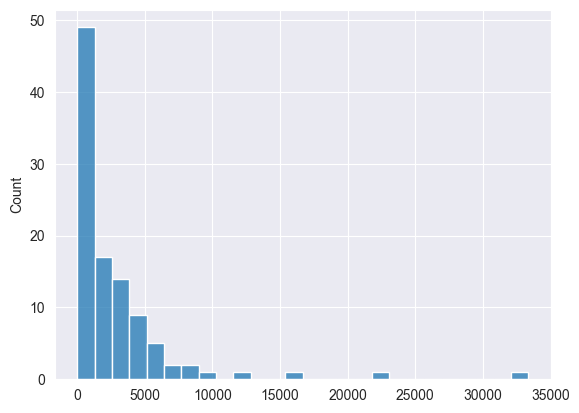

In [5]:
import seaborn as sns
sns.histplot(chunk_token_size)

In [6]:
import pandas as pd

df = pd.DataFrame(metadata)
df[df["token_count"] > 8000]

,id,title,subpart_title,section_title,content,token_count,synthesis
1,2,bsa1992214.rtf,[Part]{#_Toc187389154}1---Preliminary,,##### [1]{#_Toc187389155} Short title\nThis Ac...,10035,# Summary of the Broadcasting Services Act 199...
12,13,bsa1992214.rtf,[Part]{#_Toc187389233}[]{#_Toc187389233}[5]{#_...,[Division]{#_Toc187389248}5A---Media diversity,#### [Subdivision A]{#_Toc187389249}---Introdu...,12461,# Summary of Broadcasting Services Amendment P...
27,28,bsa1992214.rtf,[Part]{#_Toc187389407}7---Subscription televis...,[Division]{#_Toc187389417}2A---Eligible drama ...,#### [Subdivision A]{#_Toc187389418}---Introdu...,16207,# Summary of Subscription TV Drama Service Exp...
101,102,bsa1992214_2.rtf,[Endnotes]{#_Toc187389714},[Endnote 3]{#_Toc187389717}[---]{#_Toc18738971...,+-------------+-------------+-------------+---...,23040,# Summary of Legislative Acts and Amendments\n...
102,103,bsa1992214_2.rtf,[Endnotes]{#_Toc187389714},[Endnote 4]{#_Toc187389718}[---]{#_Toc18738971...,------------------------ ---------------------...,33347,# Summary of Legal Amendments and Provisions\n...


In [7]:
text = df.loc[1, "content"]
headers_to_split_on = [("#####", "Header 5"),]
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(text)

new_metadata = []
index = 0
for chunk in md_header_splits:
    chunk.page_content = "This Part {} of the *Broadcasting Services Act 1992 (BSA)*. ".format(index) + chunk.page_content
    index += 1
    new_metadata.append({
        "id": str(index),
            "values": get_embedding(chunk.page_content),
            "metadata": {
                "title": df.loc[1, "title"],
                "subpart_title": "Broadcasting Services Act 1992",
                "section_title": df.loc[1, "subpart_title"],
                "content": remove_toc_tokens(chunk.page_content),
            }})

print(len(new_metadata))
new_metadata

19


[{'id': '1',
  'values': [0.0725138783454895,
   -0.006529434118419886,
   -0.0033028717152774334,
   0.00301588186994195,
   -0.025971753522753716,
   -0.012680638581514359,
   -0.015447685495018959,
   0.03410700336098671,
   0.008128614164888859,
   0.010358177125453949,
   0.02094196528196335,
   -0.0034339248668402433,
   0.001702032401226461,
   -0.022123102098703384,
   0.005195677746087313,
   0.018951283767819405,
   -0.010889025405049324,
   0.019442319869995117,
   0.011492866091430187,
   -0.02075616829097271,
   0.010225465521216393,
   0.02901086024940014,
   -0.010338271036744118,
   -0.016429753974080086,
   -0.01523534581065178,
   0.014531971886754036,
   -0.01823463849723339,
   0.014040937647223473,
   0.013629530556499958,
   -0.04774980619549751,
   0.013350835070014,
   -0.0014888636069372296,
   -0.02291937544941902,
   -0.016389941796660423,
   -0.021565712988376617,
   -0.007949452847242355,
   0.026383159682154655,
   0.005620356183499098,
   -0.0377698577940

## Prepare Upsert Data

### Pinecone

In [8]:
for chunk in tqdm.tqdm(metadata):
    if chunk["token_count"] > 12000:
        index += 1
        new_metadata.append({
            "id": str(index),
            "values": get_embedding(chunk["synthesis"]),
            "metadata": {
                "title": chunk["title"],
                "subpart_title": chunk["subpart_title"],
                "section_title": chunk["section_title"],
                "content": remove_toc_tokens(chunk["synthesis"]),
            },
        })
    elif chunk["token_count"] > 8000:
        continue
    else:
        index += 1
        new_metadata.append({
            "id": str(index),
            "values": get_embedding(chunk["content"]),
            "metadata": {
                "title": chunk["title"],
                "subpart_title": chunk["subpart_title"],
                "section_title": chunk["section_title"],
                "content": remove_toc_tokens(chunk["content"]),
            },
        })

100%|██████████| 103/103 [01:00<00:00,  1.71it/s]


In [9]:
index

121

In [10]:
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(api_key=pinecone_api_key)
index_name = "australia-broadcasting-services-act"
# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        name=index_name,
        dimension=3072,  # dimensionality of embed 3
        metric='cosine',
        spec=ServerlessSpec(
    cloud="aws", region="us-east-1"  # us-east-1
)
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
print(index.describe_index_stats())

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}


In [11]:
index.upsert(vectors=new_metadata, batch_size=10)

Upserted vectors:   0%|          | 0/121 [00:00<?, ?it/s]

upserted_count: 121

In [12]:
print(index.describe_index_stats())

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}


In [29]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
query = "Under the Broadcasting Services Act 1992, what are the reporting obligations of a foreign person who acquires a company interest of 2.5% or more in an Australian media company?"
xq = client.embeddings.create(input=query, model="text-embedding-3-large").data[0].embedding
res = index.query(vector=xq, top_k=5, include_metadata=True)
res

{'matches': [{'id': '8',
              'metadata': {'content': 'This Part 7 of the *Broadcasting '
                                      'Services Act 1992 (BSA)*. \\(1\\) For '
                                      'the purposes of this Act:\n'
                                      '\\(a\\) a person has a shareholding '
                                      'interest in a company if the person is\n'
                                      'beneficially entitled to, or to an '
                                      'interest in, shares in the company,\n'
                                      'whether or not any part of the legal '
                                      'ownership of the shares is vested\n'
                                      'in the person; and\n'
                                      '\\(b\\) the percentage of the interest '
                                      'is the value of the shares, or of\n'
                                      'the interest in the shares, as t

In [22]:
for r in res["matches"]:
    print(r["metadata"]["content"])

This Part 7 of the *Broadcasting Services Act 1992 (BSA)*. \(1\) For the purposes of this Act:
\(a\) a person has a shareholding interest in a company if the person is
beneficially entitled to, or to an interest in, shares in the company,
whether or not any part of the legal ownership of the shares is vested
in the person; and
\(b\) the percentage of the interest is the value of the shares, or of
the interest in the shares, as the case may be, on the basis that the
value of the shares is equal to the amount paid on the shares, expressed
as a percentage of the total of all amounts paid on shares in the
company.
\(2\) For the purposes of this Act:
\(a\) a person has a voting interest in a company if the person is in a
position to exercise control of votes cast on a poll at a meeting of the
company; and
\(b\) the percentage of the interest is the greatest percentage of the
number of votes, expressed as a percentage of the total number of votes
that could be cast on any issue at a meeting 

In [32]:
res["matches"][3]["metadata"]["content"]

"#### [Subdivision A]---Introduction\n##### [74A] Simplified outline of this Division\n• The ACMA must maintain a Register of Foreign Owners of Media Assets.\n• The Register of Foreign Owners of Media Assets must set out, for each\nAustralian media company, information about each foreign stakeholder in\nthe company.\n• Foreign stakeholders must notify the ACMA of their company interests\nin Australian media companies.\nNote: For ***company interests***, see section6.\n##### [74B] Definitions\nIn this Division:\n***ACMA official ***has the same meaning as in the *Australian\nCommunications and Media Authority Act 2005*.\n***Australia***, when used in a geographical sense, includes all the\nexternal Territories.\n***Australian media company*** means:\n\\(a\\) a company that holds a commercial television broadcasting licence;\nor\n\\(b\\) a company that holds a commercial radio broadcasting licence; or\n\\(c\\) a company that is:\n\\(i\\) the publisher of a newspaper that is associated wi

In [38]:
res["matches"][3]["metadata"]["section_title"]

'[Division]{#_Toc187389345}10A---Register of Foreign Owners of Media Assets'